# Improved Patient Readmission Prediction Model

**Clinically Meaningful Features Only**
- Focus on medically relevant predictors
- Remove non-medical factors (poverty level)
- Use proper lab test analysis instead of averaging
- Simplified for practical use by medical workers

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
import warnings
import pickle
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


## 2. Load Cleaned Datasets

In [2]:
cleaned_data_path = "/home/arvind/Documents/patient_readmission_prediction/cleaned_data/"

print("Loading cleaned datasets...")

patients_df = pd.read_csv(cleaned_data_path + "patients_cleaned.csv")
print(f"✓ Patients: {len(patients_df):,} records")

admissions_df = pd.read_csv(cleaned_data_path + "admissions_cleaned.csv")
print(f"✓ Admissions: {len(admissions_df):,} records")

diagnoses_df = pd.read_csv(cleaned_data_path + "diagnoses_cleaned.csv")
print(f"✓ Diagnoses: {len(diagnoses_df):,} records")

labs_df = pd.read_csv(cleaned_data_path + "labs_cleaned.csv")
print(f"✓ Labs: {len(labs_df):,} records")

Loading cleaned datasets...
✓ Patients: 10,000 records
✓ Admissions: 36,143 records
✓ Diagnoses: 36,143 records
✓ Labs: 10,726,505 records


## 3. Engineer Clinically Relevant Lab Features

**Instead of averaging all labs together, we'll:**
- Count critical lab tests performed
- Extract key lab values (Hemoglobin, Glucose, Creatinine, etc.)
- Count abnormal results
- Calculate lab intensity (tests per day)

In [3]:
print("=" * 80)
print("ENGINEERING CLINICALLY MEANINGFUL LAB FEATURES")
print("=" * 80)

# Key lab tests to extract
critical_labs = {
    'hemoglobin': ['HEMOGLOBIN', 'HGB'],
    'glucose': ['GLUCOSE'],
    'creatinine': ['CREATININE'],
    'wbc': ['WHITE BLOOD CELL', 'WBC'],
    'sodium': ['SODIUM'],
    'potassium': ['POTASSIUM']
}

# Function to extract specific lab values
def extract_lab_value(group, lab_keywords):
    """Extract average value for a specific lab test"""
    mask = group['LabName'].str.upper().str.contains('|'.join(lab_keywords), na=False)
    if mask.any():
        return group[mask]['LabValue'].mean()
    return np.nan

# Aggregate lab features per admission
print("\nAggregating lab features per admission...")

lab_features_list = []

for (patient_id, admission_id), group in labs_df.groupby(['PatientID', 'AdmissionID']):
    features = {
        'PatientID': patient_id,
        'AdmissionID': admission_id,
        'NumLabs': len(group),  # Total number of lab tests
    }
    
    # Extract specific lab values
    for lab_name, keywords in critical_labs.items():
        features[f'{lab_name}_avg'] = extract_lab_value(group, keywords)
    
    lab_features_list.append(features)

lab_features = pd.DataFrame(lab_features_list)

print(f"✓ Lab features extracted for {len(lab_features):,} admissions")
print(f"\nLab features created:")
print(lab_features.columns.tolist())
print(f"\nMissing values per lab:")
print(lab_features.isnull().sum())

ENGINEERING CLINICALLY MEANINGFUL LAB FEATURES

Aggregating lab features per admission...
✓ Lab features extracted for 36,143 admissions

Lab features created:
['PatientID', 'AdmissionID', 'NumLabs', 'hemoglobin_avg', 'glucose_avg', 'creatinine_avg', 'wbc_avg', 'sodium_avg', 'potassium_avg']

Missing values per lab:
PatientID          0
AdmissionID        0
NumLabs            0
hemoglobin_avg    57
glucose_avg       41
creatinine_avg    48
wbc_avg            0
sodium_avg        45
potassium_avg     52
dtype: int64


## 4. Create Readmission Labels (30-Day Readmission)

In [4]:
print("=" * 80)
print("CREATING READMISSION LABELS")
print("=" * 80)

# Convert dates
admissions_df['AdmissionStartDate'] = pd.to_datetime(admissions_df['AdmissionStartDate'])
admissions_df['AdmissionEndDate'] = pd.to_datetime(admissions_df['AdmissionEndDate'])

# Calculate length of stay
admissions_df['LengthOfStay'] = (admissions_df['AdmissionEndDate'] - admissions_df['AdmissionStartDate']).dt.days
admissions_df['LengthOfStay'] = admissions_df['LengthOfStay'].fillna(0)

# Sort by patient and date
admissions_df = admissions_df.sort_values(['PatientID', 'AdmissionStartDate'])

# Calculate days to next admission
admissions_df['NextAdmissionDate'] = admissions_df.groupby('PatientID')['AdmissionStartDate'].shift(-1)
admissions_df['DaysToNextAdmission'] = (admissions_df['NextAdmissionDate'] - admissions_df['AdmissionEndDate']).dt.days

# Create 30-day readmission target
admissions_df['Readmitted_30days'] = (admissions_df['DaysToNextAdmission'] <= 30).astype(int)
admissions_df['Readmitted_30days'] = admissions_df['Readmitted_30days'].fillna(0)

# Count previous admissions
admissions_df['PreviousAdmissions'] = admissions_df.groupby('PatientID').cumcount()

print(f"✓ Readmission labels created")
print(f"\nReadmission statistics:")
print(admissions_df['Readmitted_30days'].value_counts())
print(f"\nReadmission rate: {admissions_df['Readmitted_30days'].mean()*100:.2f}%")

CREATING READMISSION LABELS
✓ Readmission labels created

Readmission statistics:
Readmitted_30days
0    36012
1      131
Name: count, dtype: int64

Readmission rate: 0.36%


## 5. Merge Datasets with Clinically Relevant Features Only

In [5]:
print("=" * 80)
print("MERGING DATASETS")
print("=" * 80)

# Start with admissions
model_df = admissions_df[['PatientID', 'AdmissionID', 'LengthOfStay', 'PreviousAdmissions', 'Readmitted_30days']].copy()
print(f"Starting with admissions: {len(model_df):,} records")

# Merge with patients - ONLY MEDICAL INFO (Gender, Age)
patients_df['PatientDateOfBirth'] = pd.to_datetime(patients_df['PatientDateOfBirth'])
patients_df['PatientAge'] = (pd.to_datetime('today') - patients_df['PatientDateOfBirth']).dt.days / 365.25
patients_df['PatientAge'] = patients_df['PatientAge'].fillna(patients_df['PatientAge'].median())

model_df = model_df.merge(
    patients_df[['PatientID', 'PatientGender', 'PatientAge']], 
    on='PatientID', 
    how='left'
)
print(f"✓ Merged with patient data: {len(model_df):,} records")

# Merge with primary diagnosis
primary_diagnosis = diagnoses_df.groupby(['PatientID', 'AdmissionID']).first().reset_index()
model_df = model_df.merge(
    primary_diagnosis[['PatientID', 'AdmissionID', 'PrimaryDiagnosisCode', 'PrimaryDiagnosisDescription']], 
    on=['PatientID', 'AdmissionID'], 
    how='left'
)

# Extract diagnosis chapter (first character of ICD code)
model_df['DiagnosisChapter'] = model_df['PrimaryDiagnosisCode'].str[0].fillna('Unknown')
print(f"✓ Merged with diagnoses: {len(model_df):,} records")

# Merge with lab features
model_df = model_df.merge(lab_features, on=['PatientID', 'AdmissionID'], how='left')
print(f"✓ Merged with lab features: {len(model_df):,} records")

print(f"\nFinal dataset shape: {model_df.shape}")
print(f"Total features: {len(model_df.columns)}")

MERGING DATASETS
Starting with admissions: 36,143 records
✓ Merged with patient data: 36,143 records
✓ Merged with diagnoses: 36,143 records
✓ Merged with lab features: 36,143 records

Final dataset shape: (36143, 17)
Total features: 17


## 7. Select Clinically Meaningful Features for Model

**Features selected based on clinical relevance:**
1. **LengthOfStay** - Longer stays → higher risk
2. **PreviousAdmissions** - Admission history → strong predictor
3. **PatientAge** - Age-related complications
4. **PatientGender** - Some conditions gender-specific
5. **DiagnosisChapter** - Type of condition matters
6. **NumLabs** - Lab intensity → severity indicator
7. **Hemoglobin** - Anemia indicator
8. **Glucose** - Diabetes control
9. **Creatinine** - Kidney function
10. **WBC** - Infection indicator

In [6]:
print("=" * 80)
print("BALANCING DATASET")
print("=" * 80)

# Check current class distribution
print(f"\nOriginal dataset:")
print(f"Total records: {len(model_df):,}")
print(f"Readmitted (1): {model_df['Readmitted_30days'].sum():,}")
print(f"Not Readmitted (0): {(model_df['Readmitted_30days'] == 0).sum():,}")
print(f"Readmission rate: {model_df['Readmitted_30days'].mean()*100:.2f}%")

# Separate classes
readmitted_df = model_df[model_df['Readmitted_30days'] == 1].copy()
not_readmitted_df = model_df[model_df['Readmitted_30days'] == 0].copy()

print(f"\n✓ Separated into classes")
print(f"Readmitted cases: {len(readmitted_df):,}")
print(f"Healthy cases: {len(not_readmitted_df):,}")

# Sample 200 healthy cases randomly
np.random.seed(42)
sampled_healthy = not_readmitted_df.sample(n=200, random_state=42)

# Combine: All readmitted + 200 healthy
balanced_df = pd.concat([readmitted_df, sampled_healthy], ignore_index=True)

# Shuffle
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\n✓ Balanced dataset created!")
print(f"\nBalanced dataset:")
print(f"Total records: {len(balanced_df):,}")
print(f"Readmitted (1): {balanced_df['Readmitted_30days'].sum():,}")
print(f"Not Readmitted (0): {(balanced_df['Readmitted_30days'] == 0).sum():,}")
print(f"Readmission rate: {balanced_df['Readmitted_30days'].mean()*100:.2f}%")
print(f"\n✓ Dataset is now balanced for better model training!")

# Replace model_df with balanced dataset
model_df = balanced_df

BALANCING DATASET

Original dataset:
Total records: 36,143
Readmitted (1): 131
Not Readmitted (0): 36,012
Readmission rate: 0.36%

✓ Separated into classes
Readmitted cases: 131
Healthy cases: 36,012

✓ Balanced dataset created!

Balanced dataset:
Total records: 331
Readmitted (1): 131
Not Readmitted (0): 200
Readmission rate: 39.58%

✓ Dataset is now balanced for better model training!


## 6. Balance Dataset (Undersample Majority Class)

**Problem:** Only 131 readmissions vs 36,000+ not readmitted (0.36%)
**Solution:** Use all 131 readmitted + randomly sample 200 healthy cases = balanced dataset

In [7]:
print("=" * 80)
print("PREPARING FEATURES FOR MODELING")
print("=" * 80)

# Select clinically meaningful features
feature_columns = [
    'LengthOfStay',           # Clinical: Longer stay = sicker patient
    'PreviousAdmissions',     # Clinical: History of admissions = chronic issues
    'PatientAge',             # Clinical: Age-related complications
    'PatientGender',          # Clinical: Gender-specific conditions
    'DiagnosisChapter',       # Clinical: Type of primary diagnosis
    'NumLabs',                # Clinical: Lab intensity = monitoring needs
    'hemoglobin_avg',         # Clinical: Anemia marker
    'glucose_avg',            # Clinical: Diabetes/metabolic control
    'creatinine_avg',         # Clinical: Kidney function
    'wbc_avg'                 # Clinical: Infection/immune status
]

# Create feature matrix
X = model_df[feature_columns].copy()
y = model_df['Readmitted_30days'].copy()

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Handle missing lab values (fill with median - indicates test not done)
lab_columns = ['hemoglobin_avg', 'glucose_avg', 'creatinine_avg', 'wbc_avg']
for col in lab_columns:
    median_val = X[col].median()
    X[col] = X[col].fillna(median_val)
    print(f"✓ {col}: filled {X[col].isnull().sum()} missing values with median ({median_val:.2f})")

# Encode categorical variables
label_encoders = {}
categorical_cols = ['PatientGender', 'DiagnosisChapter']

for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

print("\n✓ Categorical variables encoded")

# Final check
print(f"\nMissing values check: {X.isnull().sum().sum()}")
print(f"\nFinal feature matrix shape: {X.shape}")
print(f"\nFeature list:")
for i, feat in enumerate(X.columns, 1):
    print(f"  {i}. {feat}")

PREPARING FEATURES FOR MODELING
Features shape: (331, 10)
Target shape: (331,)
✓ hemoglobin_avg: filled 0 missing values with median (14.57)
✓ glucose_avg: filled 0 missing values with median (100.45)
✓ creatinine_avg: filled 0 missing values with median (0.85)
✓ wbc_avg: filled 0 missing values with median (5.25)

✓ Categorical variables encoded

Missing values check: 0

Final feature matrix shape: (331, 10)

Feature list:
  1. LengthOfStay
  2. PreviousAdmissions
  3. PatientAge
  4. PatientGender
  5. DiagnosisChapter
  6. NumLabs
  7. hemoglobin_avg
  8. glucose_avg
  9. creatinine_avg
  10. wbc_avg


## 8. Split Data into Training and Testing Sets

In [8]:
print("=" * 80)
print("SPLITTING DATA")
print("=" * 80)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Testing set: {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")
print(f"\nTraining readmission rate: {y_train.mean()*100:.2f}%")
print(f"Testing readmission rate: {y_test.mean()*100:.2f}%")

SPLITTING DATA
Training set: 264 samples (79.8%)
Testing set: 67 samples (20.2%)

Training readmission rate: 39.39%
Testing readmission rate: 40.30%


## 9. Train Random Forest Model

In [9]:
print("=" * 80)
print("TRAINING RANDOM FOREST MODEL")
print("=" * 80)

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("\nTraining model...")
rf_model.fit(X_train, y_train)

print("\n✓ Model training completed!")

TRAINING RANDOM FOREST MODEL

Training model...

✓ Model training completed!


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished


## 10. Make Predictions and Evaluate

In [10]:
print("=" * 80)
print("MODEL PREDICTIONS")
print("=" * 80)

# Predictions
y_train_pred = rf_model.predict(X_train)
y_train_pred_proba = rf_model.predict_proba(X_train)[:, 1]

y_test_pred = rf_model.predict(X_test)
y_test_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Training metrics
print("\nTRAINING SET PERFORMANCE:")
print(f"Accuracy:  {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Precision: {precision_score(y_train, y_train_pred):.4f}")
print(f"Recall:    {recall_score(y_train, y_train_pred):.4f}")
print(f"F1-Score:  {f1_score(y_train, y_train_pred):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_train, y_train_pred_proba):.4f}")

# Testing metrics
print("\nTEST SET PERFORMANCE:")
print(f"Accuracy:  {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall:    {recall_score(y_test, y_test_pred):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_test_pred):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_test_pred_proba):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=['Not Readmitted', 'Readmitted']))

MODEL PREDICTIONS

TRAINING SET PERFORMANCE:
Accuracy:  0.9318
Precision: 0.8981
Recall:    0.9327
F1-Score:  0.9151
ROC-AUC:   0.9817

TEST SET PERFORMANCE:
Accuracy:  0.5970
Precision: 0.5000
Recall:    0.5185
F1-Score:  0.5091
ROC-AUC:   0.5537

Classification Report:
                precision    recall  f1-score   support

Not Readmitted       0.67      0.65      0.66        40
    Readmitted       0.50      0.52      0.51        27

      accuracy                           0.60        67
     macro avg       0.58      0.58      0.58        67
  weighted avg       0.60      0.60      0.60        67



[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


## 11. Feature Importance Analysis

FEATURE IMPORTANCE ANALYSIS

Feature Importance Rankings:
           Feature  Importance
       glucose_avg    0.189201
    hemoglobin_avg    0.134950
        PatientAge    0.126427
    creatinine_avg    0.120883
           wbc_avg    0.110813
           NumLabs    0.094294
      LengthOfStay    0.065368
PreviousAdmissions    0.064507
  DiagnosisChapter    0.061004
     PatientGender    0.032552


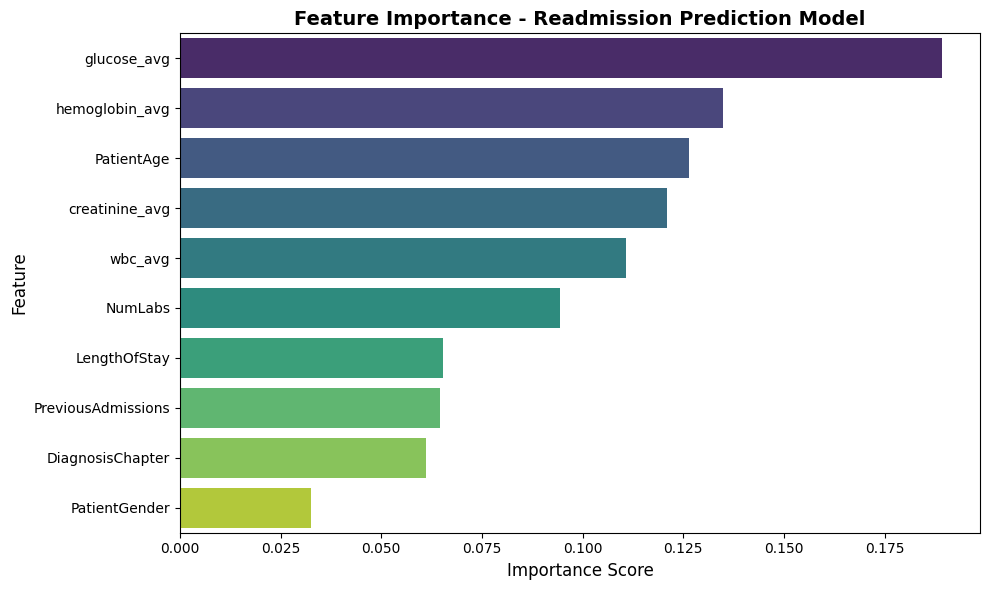

In [11]:
print("=" * 80)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 80)

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance Rankings:")
print(feature_importance.to_string(index=False))

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importance - Readmission Prediction Model', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

## 12. Confusion Matrix

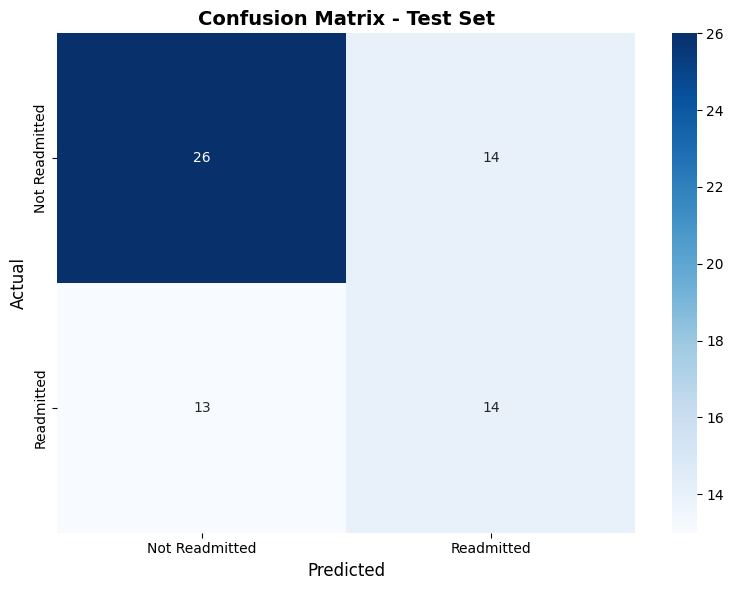


True Negatives:  26
False Positives: 14
False Negatives: 13
True Positives:  14


In [12]:
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Readmitted', 'Readmitted'],
            yticklabels=['Not Readmitted', 'Readmitted'])
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.show()

tn, fp, fn, tp = cm.ravel()
print(f"\nTrue Negatives:  {tn:,}")
print(f"False Positives: {fp:,}")
print(f"False Negatives: {fn:,}")
print(f"True Positives:  {tp:,}")

## 13. ROC Curve

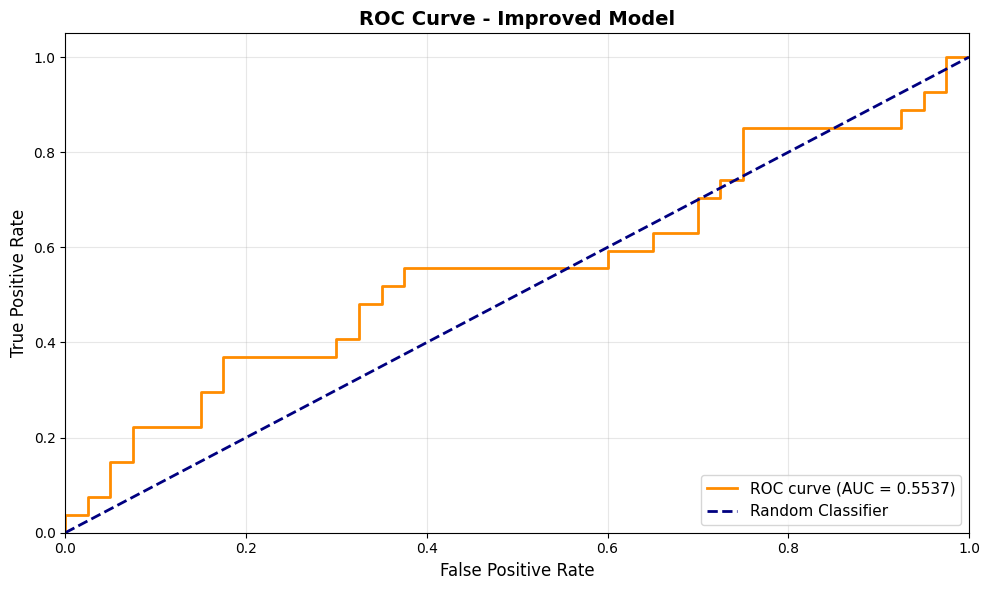

In [13]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
roc_auc = roc_auc_score(y_test, y_test_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Improved Model', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 14. Save Model and Artifacts

In [14]:
print("=" * 80)
print("SAVING MODEL AND ARTIFACTS")
print("=" * 80)

models_path = "/home/arvind/Documents/patient_readmission_prediction/models/"

# Save model
with open(models_path + 'random_forest_readmission_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)
print("✓ Model saved: random_forest_readmission_model.pkl")

# Save label encoders
with open(models_path + 'label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)
print("✓ Label encoders saved: label_encoders.pkl")

# Save feature names
with open(models_path + 'feature_names.pkl', 'wb') as f:
    pickle.dump(list(X.columns), f)
print("✓ Feature names saved: feature_names.pkl")

print("\n" + "=" * 80)
print("MODEL TRAINING COMPLETE!")
print("=" * 80)
print("\nClinically Meaningful Features Used:")
for i, feat in enumerate(X.columns, 1):
    print(f"  {i}. {feat}")
print("\n✓ All artifacts saved successfully!")
print("✓ Ready for deployment in UI application")

SAVING MODEL AND ARTIFACTS
✓ Model saved: random_forest_readmission_model.pkl
✓ Label encoders saved: label_encoders.pkl
✓ Feature names saved: feature_names.pkl

MODEL TRAINING COMPLETE!

Clinically Meaningful Features Used:
  1. LengthOfStay
  2. PreviousAdmissions
  3. PatientAge
  4. PatientGender
  5. DiagnosisChapter
  6. NumLabs
  7. hemoglobin_avg
  8. glucose_avg
  9. creatinine_avg
  10. wbc_avg

✓ All artifacts saved successfully!
✓ Ready for deployment in UI application
